In [1]:
import skimage
import time
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from imageio.v2 import imsave,imread
from keras import optimizers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from scipy.ndimage import binary_fill_holes
from tqdm import trange

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dim=64

In [43]:
try:
  X_all=np.load('./drive/MyDrive/Colab Notebooks/X.npy')
  Y_all=np.load('./drive/MyDrive/Colab Notebooks/Y.npy')
  bg=np.load('./drive/MyDrive/Colab Notebooks/bg.npy')
  tbg=np.load('./drive/MyDrive/Colab Notebooks/tbg.npy')
  rooms=np.load('./drive/MyDrive/Colab Notebooks/rooms.npy')
except Exception:
  X_all=np.load('./drive/MyDrive/X.npy')
  Y_all=np.load('./drive/MyDrive/Y.npy')
  bg=np.load('./drive/MyDrive/bg.npy')
  tbg=np.load('./drive/MyDrive/tbg.npy')
  rooms=np.load('./drive/MyDrive/rooms.npy')

In [44]:
def binarize(img):
  v=[[],[],[],[]]
  prew_img=skimage.filters.prewitt(img)
  threshold=skimage.filters.threshold_otsu(prew_img)
  for x in range(64):
    for y in range(64):
      if prew_img[x,y]<=threshold: 
        prew_img[x,y]=0
      else: 
        prew_img[x,y]=1
  img=prew_img.copy()
  l=list(img[0])
  if 1 in l:
    v[0].append(l.index(1))
    l.reverse()
    v[0].append(62-l.index(1))
  l=list(img[:,0])
  if 1 in l:
    v[1].append(l.index(1))
    l.reverse()
    v[1].append(62-l.index(1))
  l=list(img[63])
  if 1 in l:
    v[2].append(l.index(1))
    l.reverse()
    v[2].append(62-l.index(1))
  l=list(img[:,63])
  if 1 in l:
    v[3].append(l.index(1))
    l.reverse()
    v[3].append(62-l.index(1))
  for i in range(4):
    if len(v[i])!=0:
      if abs(v[i][0]-v[i][1])<=1:
        v[i][v[i].index(max(v[i]))]=63
        v[i].sort()
  for x in range(64):
    for y in range(64):
      if prew_img[x,y]==1 or (len(v[1])!=0 and (x in range(min(v[1]),max(v[1])+1))):
        img[x,y:]=1
        break
  for x in range(64):
    for y in range(63,-1,-1):
      if prew_img[x,y]==1 and not (len(v[3])!=0 and (x in range(min(v[3]),max(v[3])+1))):
        img[x,y:]=0
        break
  for y in range(64):
    for x in range(64):
      if prew_img[x,y]==1 and not (len(v[0])!=0 and (y in range(min(v[0]),max(v[0])+1))):
        img[:x,y]=0
        break
  return img

In [45]:
def ds_info(labels):
  var={}
  for i in range(2062):
    num=list(labels[i]).index(1.0)
    if num not in var.keys():
      k=1
      var[num]=k
    else:
      k+=1
      var[num]=k
  return var

In [46]:
def plot_acc(history):
    plt.figure(figsize=[4,4])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model\'s accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    plt.figure(figsize=[4,4])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model\'s loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [47]:
def create_network():
  model = Sequential()

  model.add(Conv2D(9, 2, activation='relu',input_shape=(dim,dim,1)))
  model.add(MaxPooling2D((2, 2)))
     
  model.add(Conv2D(9, 2, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(9, 2, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
          
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(11, activation='softmax'))
        
  return model

In [48]:
k=3
X_all_new=np.zeros((2062*k,1,64,64,1))
for i in range(k):
  X_all_new[2062*i:2062*i+2062,0]=np.expand_dims(X_all,axis=-1)
datagen = ImageDataGenerator(width_shift_range=0.08,
                             height_shift_range=0.08,
                             horizontal_flip=True,
                             rotation_range=15,
                             zoom_range=[0.76,0.97])
for i in trange(k*2062):
  train_generator = datagen.flow(X_all_new[i], batch_size=1)
  image_batch = train_generator.next()
  image = image_batch[0].astype('float32')
  X_all_new[i]=image.copy()
  image_batch=0
  image=0
datagen=0
train_generator=0
X_all=X_all_new[:,0,:,:,0].copy()
X_all_new=0

100%|██████████| 6186/6186 [00:03<00:00, 1783.93it/s]


In [49]:
Y_all_new=np.zeros((k*2062,10))
for i in range(k):
    Y_all_new[2062*i:2062*i+2062]=Y_all
Y_all=Y_all_new.copy()
Y_all_new=0

In [52]:
X_all_bin=X_all.copy()
r=0
f=False
for i in trange(2062*k):
  X_all_bin[i]=binarize(X_all_bin[i])
  img=X_all[i].copy()
  img=Image.fromarray(img*255).convert('RGB')
  enh=PIL.ImageEnhance.Contrast(img)
  img=enh.enhance(0.3)
  enh=PIL.ImageEnhance.Brightness(img)
  img=enh.enhance(0.2)
  img=np.array(img)[:,:,0].astype('float32')/255
  if not f: b=bg[r].copy()
  else: b=tbg[r].copy()
  b=Image.fromarray(b*255).convert('RGB')
  enh=PIL.ImageEnhance.Brightness(b)
  b=enh.enhance(0.7)
  b=np.array(b)[:,:,0].astype('float32')/255
  for x in range(64):
    for y in range(64):
      if X_all_bin[i,x,y]==0: X_all_bin[i,x,y]=b[x,y]
      else: X_all_bin[i,x,y]=img[x,y]
  r+=1
  if r>=len(X_all_bin)//2: r,f=0,True
X_all=0

100%|██████████| 6186/6186 [00:57<00:00, 107.33it/s]


IndexError: ignored

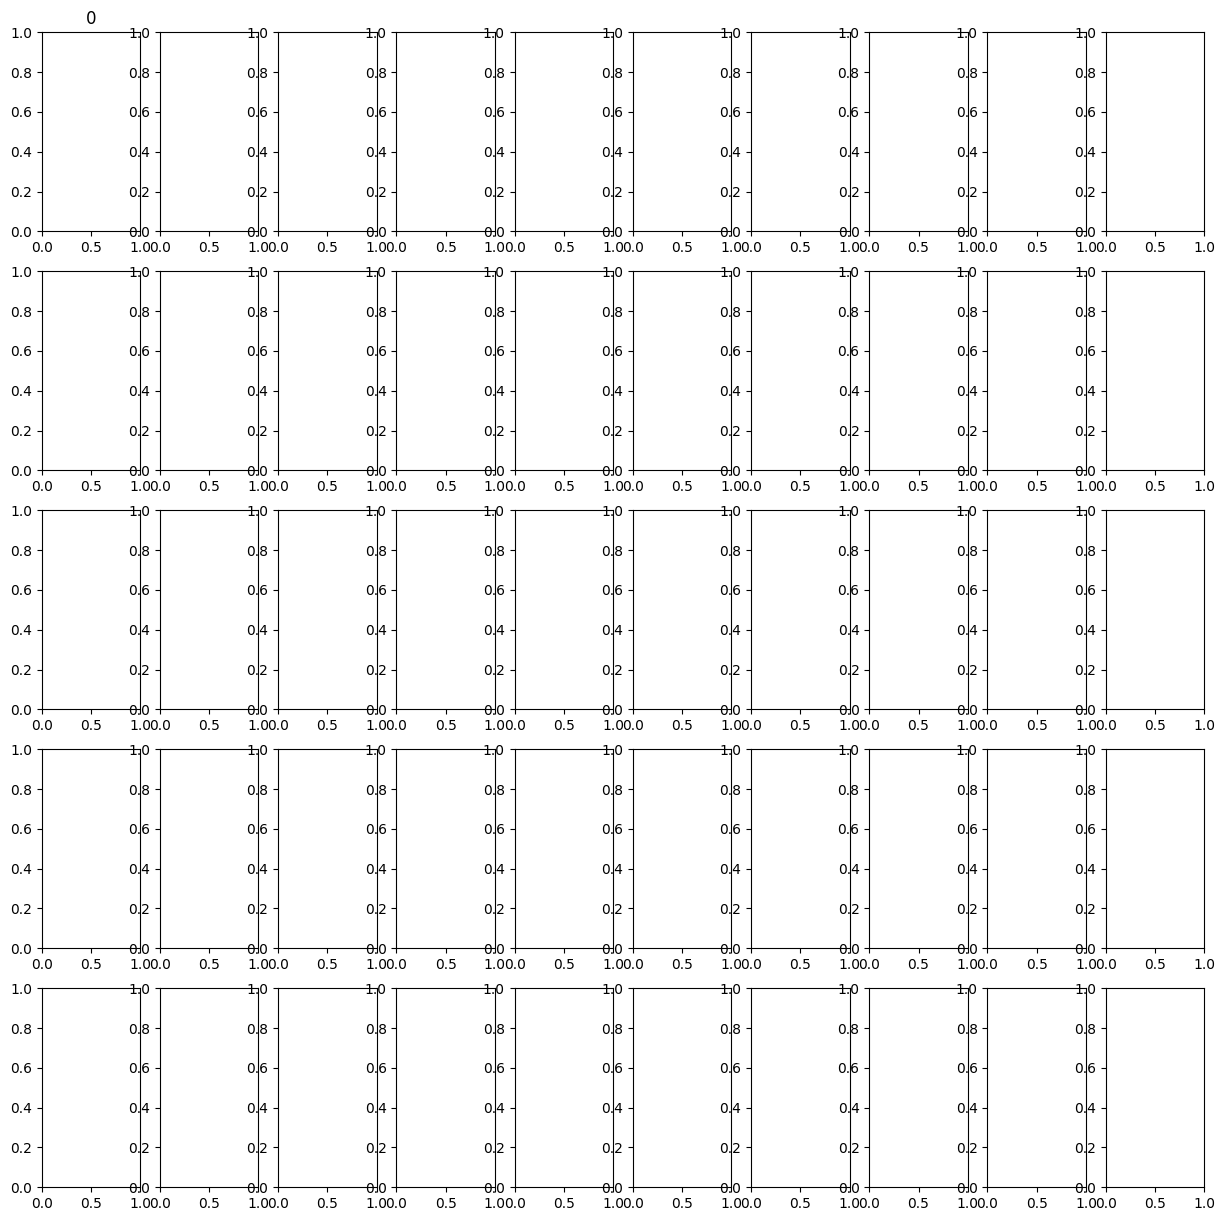

In [53]:
f,ax=plt.subplots(5,10,figsize=(15,15))
for i in range(10):
  ax[0][i].set_title(str(i))
  low=np.random.randint(0,2062*k)
  while list(Y_all[low]).index(1.0)!=i:
    low+=1
  high=low
  while list(Y_all[high]).index(1.0)==i:
    high+=1
    if high==2062*k-1:
      high=2062*k
      break
  high-=1
  for a in range(5):
    r=np.random.randint(low,high)
    ax[a][i].imshow(X_all_bin[r],cmap='gray',vmin=0,vmax=1)
    ax[a][i].set_title(str(r))
    ax[a][i].set_axis_off()

In [54]:
X_new=np.zeros((13506,64,64))
X_new[:2062*k]=X_all_bin.copy()
X_new[2062*k:2062*k+3800]=bg.copy()
X_new[2062*k+3800:]=tbg.copy()
Y_new=np.zeros((13506,11))
Y_new[:2062*k,1:]=Y_all.copy()
Y_new[2062*k:,0]=1

In [55]:
X_new=np.expand_dims(X_new,axis=-1)
x_train, x_test, y_train, y_test=train_test_split(X_new,Y_new,test_size=0.3,random_state=42)
x_train = x_train.astype('float32')*255
x_test  = x_test.astype('float32')*255
X_new=0

Epoch 1/30
379/379 [==============================] - 5s 6ms/step - loss: 1.6895 - accuracy: 0.6788 - val_loss: 0.7679 - val_accuracy: 0.7507
Epoch 2/30
379/379 [==============================] - 2s 6ms/step - loss: 0.6686 - accuracy: 0.7737 - val_loss: 0.6368 - val_accuracy: 0.7841
Epoch 3/30
379/379 [==============================] - 2s 6ms/step - loss: 0.5448 - accuracy: 0.8129 - val_loss: 0.6388 - val_accuracy: 0.7885
Epoch 4/30
379/379 [==============================] - 3s 7ms/step - loss: 0.4578 - accuracy: 0.8440 - val_loss: 0.5788 - val_accuracy: 0.8077
Epoch 5/30
379/379 [==============================] - 2s 6ms/step - loss: 0.3741 - accuracy: 0.8726 - val_loss: 0.5657 - val_accuracy: 0.8186
Epoch 6/30
379/379 [==============================] - 2s 5ms/step - loss: 0.3042 - accuracy: 0.8975 - val_loss: 0.5499 - val_accuracy: 0.8272
Epoch 7/30
379/379 [==============================] - 2s 6ms/step - loss: 0.2430 - accuracy: 0.9182 - val_loss: 0.5703 - val_accuracy: 0.8309
Epoch 

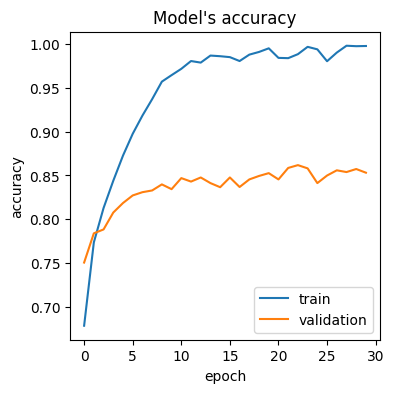

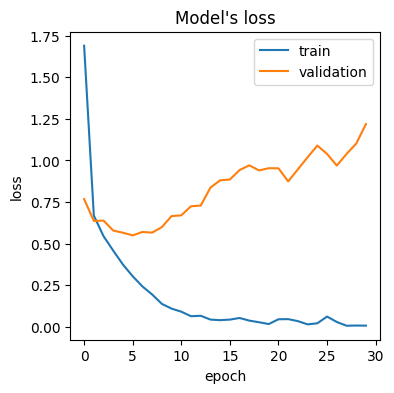

In [59]:
model=create_network()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,
                  validation_data=(x_test,y_test),
                  callbacks=None,
                  epochs=30,
                  batch_size=25)
scores=model.evaluate(x_test,y_test)
print('Train accuracy: %.2f%%' % (history.history['accuracy'][-1]*100))
print('Validation accuracy: %.2f%%' % (scores[1]*100))
print('Accuracy and loss plot:')
plot_acc(history)

In [60]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices(x_train).batch(1):
    yield [tf.dtypes.cast(data, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [61]:
with open('./drive/MyDrive/model.tflite', 'wb') as output:
    print(len(tflite_quant_model))
    output.write(tflite_quant_model)

64768
